In [ ]:
import os                     # to work with folders and files
import numpy as np            # for numerical operations
import matplotlib.pyplot as plt  # to visualize images

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import zipfile

with zipfile.ZipFile('/content/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [ ]:
import shutil

source_base = "/content/COVID-19_Radiography_Dataset"
final_path = "/content/final_dataset"
os.makedirs(final_path, exist_ok=True)

classes = ['COVID', 'Normal', 'Viral Pneumonia']
for cls in classes:
    src_folder = os.path.join(source_base, cls, 'images')
    dest_folder = os.path.join(final_path, cls)
    os.makedirs(dest_folder, exist_ok=True)

    for file in os.listdir(src_folder):
        src_file = os.path.join(src_folder, file)
        dst_file = os.path.join(dest_folder, file)
        shutil.copy(src_file, dst_file)

print("✅ All image folders organized.")

✅ All image folders organized.


In [ ]:
for cls in classes:
    print(cls, ":", len(os.listdir(os.path.join(final_path, cls))))

COVID : 3616
Normal : 10192
Viral Pneumonia : 1345


In [ ]:
import pandas as pd
from sklearn.utils import resample

# Build dataframe of image paths and labels
image_paths = []
labels = []

for cls in classes:
    class_folder = os.path.join(final_path, cls)
    for file in os.listdir(class_folder):
        image_paths.append(os.path.join(class_folder, file))
        labels.append(cls)

df = pd.DataFrame({'filepath': image_paths, 'label': labels})

# Split & downsample
dfs = []
min_count = 1345  # smallest class

for cls in classes:
    df_cls = df[df['label'] == cls]
    if len(df_cls) > min_count:
        df_cls = resample(df_cls, replace=False, n_samples=min_count, random_state=42)
    dfs.append(df_cls)

df_balanced = pd.concat(dfs).reset_index(drop=True)

print(df_balanced['label'].value_counts())

label
COVID              1345
Normal             1345
Viral Pneumonia    1345
Name: count, dtype: int64


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

train_data = datagen.flow_from_dataframe(
    dataframe=df_balanced,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    subset='training',
    shuffle=True
)

val_data = datagen.flow_from_dataframe(
    dataframe=df_balanced,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    subset='validation',
    shuffle=False
)

Found 3228 validated image filenames belonging to 3 classes.
Found 807 validated image filenames belonging to 3 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 64s 576ms/step - accuracy: 0.5970 - loss: 2.6082 - val_accuracy: 0.0037 - val_loss: 2.0389
Epoch 2/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 53s 528ms/step - accuracy: 0.7619 - loss: 0.5318 - val_accuracy: 0.0731 - val_loss: 1.3194
Epoch 3/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 54s 531ms/step - accuracy: 0.7793 - loss: 0.4873 - val_accuracy: 0.1574 - val_loss: 1.4118
Epoch 4/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 55s 538ms/step - accuracy: 0.7944 - loss: 0.4502 - val_accuracy: 0.1561 - val_loss: 1.3843
Epoch 5/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 54s 535ms/step - accuracy: 0.7920 - loss: 0.4709 - val_accuracy: 0.2974 - val_loss: 1.2273
Epoch 6/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 54s 536ms/step - accuracy: 0.7989 - loss: 0.4492 - val_accuracy: 0.3854 - val_loss: 0.9632
Epoch 7/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 54s 530ms/step - accuracy: 0.8051 - loss: 0.4127 - val_accuracy: 0.4188 - val_loss: 0.9811
Epoch 8/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 53s 524ms/step - accuracy: 0.8274 - loss: 0

In [ ]:
model.save("covid_xray_model.keras")
print("✅ Model saved.")

✅ Model saved.


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img('/content/normal.jpeg', target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)
labels = ['COVID', 'NORMAL', 'Viral Pneumonia']
print("Predicted:", labels[np.argmax(pred)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted: NORMAL


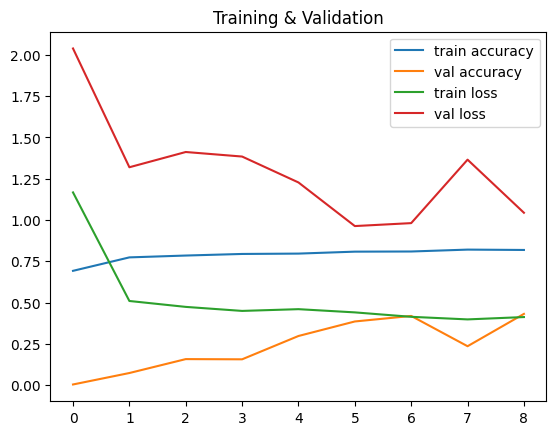

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Training & Validation')
plt.legend()
plt.show()

In [ ]:
from google.colab import files

# 3. Download to your device
files.download("covid_xray_model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>